In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import PIL.Image

from dm_control import mjcf
from dm_control import viewer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


physics.data.qvel = array([0., 0.])
physics.data.qpos = array([0., 0.])
physics.data.ctrl = array([0.])


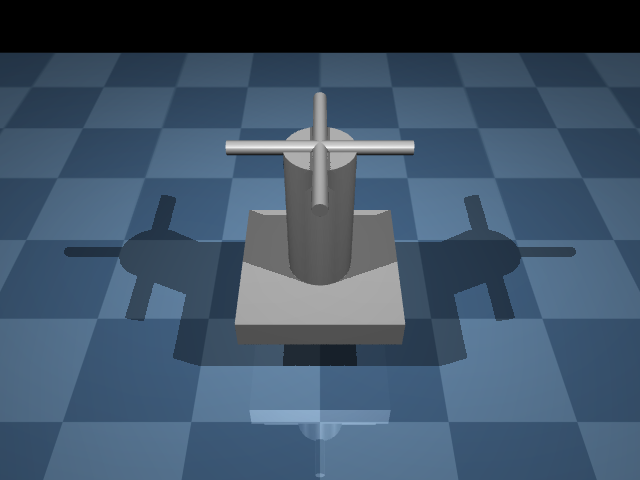

In [2]:
RENDER_WIDTH = 640
RENDER_HEIGHT = 480

TWO_D_MOVEMENT = False

env = mjcf.RootElement()

getattr(env.visual, 'global').offwidth = RENDER_WIDTH
getattr(env.visual, 'global').offheight = RENDER_HEIGHT

chequered = env.asset.add('texture', type='2d', builtin='checker', width=300,
                            height=300, rgb1=[.2, .3, .4], rgb2=[.3, .4, .5])
grid = env.asset.add('material', name='grid', texture=chequered,
                       texrepeat=[5, 5], reflectance=.2)
env.worldbody.add('geom', type='plane', size=[2, 2, .1], material=grid)

for x in [-2, 2]:
  env.worldbody.add('light', pos=[x, -1, 3], dir=[-x, 1, -2])

cart = mjcf.RootElement()
cart.compiler.angle = 'radian'

base = cart.worldbody.add('body')
base.add('geom', type='box', size=[0.25, 0.25, 0.05])

appendage = base.add('body', pos=[0, 0, 0.0])
appendage.add('geom',  type='cylinder', fromto=[0, 0, 0, 0, 0, 0.5], size=[0.1])
appendage.add('geom', type='cylinder', fromto=[-0.25, 0, 0.5, 0.25, 0, 0.5], size=[0.02])
appendage.add('geom', type='cylinder', fromto=[0, -0.25, 0.5, 0, 0.25, 0.5], size=[0.02])

hinge1 = appendage.add('joint', type='hinge', axis=[0, 1, 0], range=[-np.pi/3, np.pi/3])
slide1 = base.add('joint', type='slide', axis=[1, 0, 0], name='s1')
cart.actuator.add('motor', joint=slide1)

if TWO_D_MOVEMENT:
    hinge2 = appendage.add('joint', type='hinge', axis=[1, 0, 0], range=[-np.pi/3, np.pi/3])
    slide2 = base.add('joint', type='slide', axis=[0, 1, 0], name='s2')
    cart.actuator.add('motor', joint=slide2)

spawn_site = env.worldbody.add('site', pos=[0, 0, 0.25])
cart = spawn_site.attach(cart) 


physics = mjcf.Physics.from_mjcf_model(env)

print(f'{physics.data.qvel = }')
print(f'{physics.data.qpos = }')
print(f'{physics.data.ctrl = }')
PIL.Image.fromarray(physics.render(width=RENDER_WIDTH, height=RENDER_HEIGHT, camera_id=-1))

In [4]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=-1)
        return x    
    
def reset(physics):
    physics.reset()
    physics.data.qpos[:] = (np.random.random(physics.data.qpos.size) - 0.5) / 10


def get_state(physics):
    return np.concatenate([physics.data.qpos, physics.data.qvel])


def apply_action(physics, action):
    physics.set_control((action * 2 - 1) * 100)


def calc_reward_and_done(physics):
    if np.any(np.abs(physics.data.qpos) > 0.8):
        return -10, True
    
    if physics.data.time > 10:
        return 1000, True
    
    return 1, False


def select_action(policy, state):
    action_probs = policy(state)
            
    action_dist = torch.distributions.Categorical(action_probs)
    action = action_dist.sample()
    
    return action.item(), action_dist.log_prob(action)


def reinforce(physics, policy, optimizer, num_episodes, gamma, max_duration=10.0):
    for episode in range(num_episodes):
        reset(physics)
        done = False
        
        log_prob_actions = []
        rewards = []
        
        actions = []
        
        while not done:
            state = torch.FloatTensor(get_state(physics))
            
            action, action_log_prob = select_action(policy, state)
            apply_action(physics, action)
            log_prob_actions.append(action_log_prob)
            
            physics.step()
            
            reward, done = calc_reward_and_done(physics)
            rewards.append(reward)
        
        returns = []
        running_add = 0
        for r in rewards[::-1]:
            running_add = r + gamma * running_add
            returns.append(running_add)
        returns = torch.tensor(returns[::-1])
        returns = (returns - returns.mean()) / (returns.std() + 1e-6)
        
        policy_loss = torch.sum(-torch.stack(log_prob_actions) * returns.unsqueeze(1))
        
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        # Print episode information
        if ((episode + 1) % 1) == 0:
            print(f"Episode {episode + 1}, Total Reward: {sum(rewards)}")


policy_net = PolicyNetwork(4, 128, 2)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-2)

reinforce(physics, policy_net, optimizer, 250, 0.99)


Episode 1, Total Reward: 367
Episode 2, Total Reward: 272
Episode 3, Total Reward: 236
Episode 4, Total Reward: 226
Episode 5, Total Reward: 174
Episode 6, Total Reward: 169
Episode 7, Total Reward: 175
Episode 8, Total Reward: 179
Episode 9, Total Reward: 165
Episode 10, Total Reward: 161
Episode 11, Total Reward: 176
Episode 12, Total Reward: 193
Episode 13, Total Reward: 160
Episode 14, Total Reward: 159
Episode 15, Total Reward: 172
Episode 16, Total Reward: 180
Episode 17, Total Reward: 178
Episode 18, Total Reward: 185
Episode 19, Total Reward: 161
Episode 20, Total Reward: 155
Episode 21, Total Reward: 154
Episode 22, Total Reward: 155
Episode 23, Total Reward: 163
Episode 24, Total Reward: 189
Episode 25, Total Reward: 180
Episode 26, Total Reward: 186
Episode 27, Total Reward: 180
Episode 28, Total Reward: 156
Episode 29, Total Reward: 164
Episode 30, Total Reward: 165
Episode 31, Total Reward: 160
Episode 32, Total Reward: 156
Episode 33, Total Reward: 158
Episode 34, Total R

In [7]:
duration = 5   # (Seconds)
framerate = 30  # (Hz)
video = []
 
last_switch = 0


physics.reset()
# reset(physics)

while physics.data.time < duration:
    state = torch.FloatTensor(get_state(physics))
    action, _ = select_action(policy_net, state)
    # action = 1 if (state[1] > 0).item() else 0
    apply_action(physics, action)
    
    
    physics.step()

    if len(video) < physics.data.time * framerate:
        
        pixels = physics.render(width=RENDER_WIDTH, height=RENDER_HEIGHT, camera_id=-1)
        video.append(pixels.copy())
    
 

display_video(video, framerate)

C:\Users\Brn\AppData\Local\Temp\ipykernel_15896\2271421933.py:7: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use(orig_backend)  # Switch back to the original backend.


In [6]:
def display_video(frames, framerate=30):
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])

    def update(frame):
        im.set_data(frame)
        return [im]

    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [ ]:
physics.data.qpos

array([ 0.80046674, -1.047949  ])

In [122]:
np.concatenate([physics.data.qpos, physics.data.qvel])

array([-0.02168953, -0.03073212,  0.38963361, -0.20229654,  0.22114658,
        0.18125404, -1.93815623,  2.08265143])